In [2]:
import tensorflow as tf
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.losses import LogCosh
from keras.metrics import MeanSquaredError, MeanAbsoluteError,RootMeanSquaredError
from keras import Sequential, layers
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import numpy as np
import glob
import os

2024-08-20 13:07:33.657714: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-20 13:07:33.657815: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-20 13:07:33.794713: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Hyper parameters
PATCH_SIZE = 64
BATCH_SIZE = 200
EPOCHS = 80

In [4]:
val_files = {
    "../patches-64/skull_decimated.npy", 
    "../patches-64/ant_decimated.npy", 
    "../patches-64/vase_decimated.npy", 
    "../patches-64/isis_decimated.npy", 
    "../patches-64/teddy_decimated.npy",
    "../patches-64/teapot_decimated.npy"
}

patche_files = sorted(glob.glob('../patches-64/*.npy'))
patche_files = list(set(patche_files) - val_files)
saliency_files = [
    f"../3d-meshes/{os.path.basename(f).replace('.npy', '.txt')}" 
    for f in patche_files
]

print('Number of patches:', len(patche_files))
print('Number of saliency maps:', len(saliency_files))

Number of patches: 43
Number of saliency maps: 43


In [5]:
X_train = np.concatenate([np.load(f, mmap_mode="r").astype(np.uint8) for f in patche_files])
y_train = np.concatenate([np.loadtxt(f).astype(np.float32) for f in saliency_files])
    
X_train, y_train = shuffle(X_train, y_train)
X_train.shape, y_train.shape, X_train.dtype, y_train.dtype

((859999, 64, 64, 3), (859999,), dtype('uint8'), dtype('float32'))

In [6]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')
model = Sequential()

model.add(layers.Conv2D(filters = 16, kernel_size = (3,3), activation ='relu',
                        input_shape=(PATCH_SIZE, PATCH_SIZE, 3), padding="same", strides=(1, 1)))
model.add(layers.BatchNormalization(axis=3))
model.add(layers.Conv2D(filters = 16, kernel_size = (3,3), activation ='relu', padding="same", strides=(1, 1)))
model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2, 2), padding="valid"))
model.add(layers.BatchNormalization(axis=3))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(filters = 32, kernel_size = (3,3), activation ='relu', padding="same", strides=(1, 1)))
model.add(layers.BatchNormalization(axis=3))
model.add(layers.Conv2D(filters = 32, kernel_size = (3,3), activation ='relu', padding="same", strides=(1, 1)))
model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2, 2), padding="valid"))
model.add(layers.BatchNormalization(axis=3))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(filters = 64, kernel_size = (3,3), activation ='relu', padding="same", strides=(1, 1)))
model.add(layers.BatchNormalization(axis=3))
model.add(layers.Conv2D(filters = 64, kernel_size = (3,3), activation ='relu', padding="same", strides=(1, 1)))
model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2, 2), padding="valid"))
model.add(layers.BatchNormalization(axis=3))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())

model.add(layers.Dense(256, activation = "relu")) #Fully connected layer
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(64, activation = "relu")) #Fully connected layer
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(1, activation = "sigmoid")) # output layer

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)

model.compile(optimizer=optimizer, loss=LogCosh(), metrics=[
            MeanSquaredError(name='mse'),
            MeanAbsoluteError(name='mae'),
            RootMeanSquaredError(name='rmse'),
])

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,139,601 (4.35 MB)

 Trainable params: 1,138,513 (4.34 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [7]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [8]:
# fit the model
saliency_model = model.fit(
    X_train, y_train, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    validation_split=0.2, 
    verbose=1,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/80
   6/3440 ━━━━━━━━━━━━━━━━━━━━ 1:23 24ms/step - loss: 0.1378 - mae: 0.4590 - mse: 0.3007 - rmse: 0.5483

I0000 00:00:1724159421.117281      82 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3440/3440 ━━━━━━━━━━━━━━━━━━━━ 106s 23ms/step - loss: 0.0590 - mae: 0.2579 - mse: 0.1275 - rmse: 0.3498 - val_loss: 0.0166 - val_mae: 0.1143 - val_mse: 0.0355 - val_rmse: 0.1885 - learning_rate: 1.0000e-04
Epoch 2/80
3440/3440 ━━━━━━━━━━━━━━━━━━━━ 54s 16ms/step - loss: 0.0176 - mae: 0.1138 - mse: 0.0378 - rmse: 0.1943 - val_loss: 0.0141 - val_mae: 0.1030 - val_mse: 0.0299 - val_rmse: 0.1729 - learning_rate: 1.0000e-04
Epoch 3/80
3440/3440 ━━━━━━━━━━━━━━━━━━━━ 53s 15ms/step - loss: 0.0145 - mae: 0.1035 - mse: 0.0308 - rmse: 0.1754 - val_loss: 0.0126 - val_mae: 0.0986 - val_mse: 0.0266 - val_rmse: 0.1630 - learning_rate: 1.0000e-04
Epoch 4/80
3440/3440 ━━━━━━━━━━━━━━━━━━━━ 53s 15ms/step - loss: 0.0128 - mae: 0.0985 - mse: 0.0268 - rmse: 0.1636 - val_loss: 0.0113 - val_mae: 0.0896 - val_mse: 0.0237 - val_rmse: 0.1539 - learning_rate: 1.0000e-04
Epoch 5/80
3440/3440 ━━━━━━━━━━━━━━━━━━━━ 53s 15ms/step - loss: 0.0114 - mae: 0.0923 - mse: 0.0238 - rmse: 0.1542 - val_loss: 0.0094 - val_mae: 0.

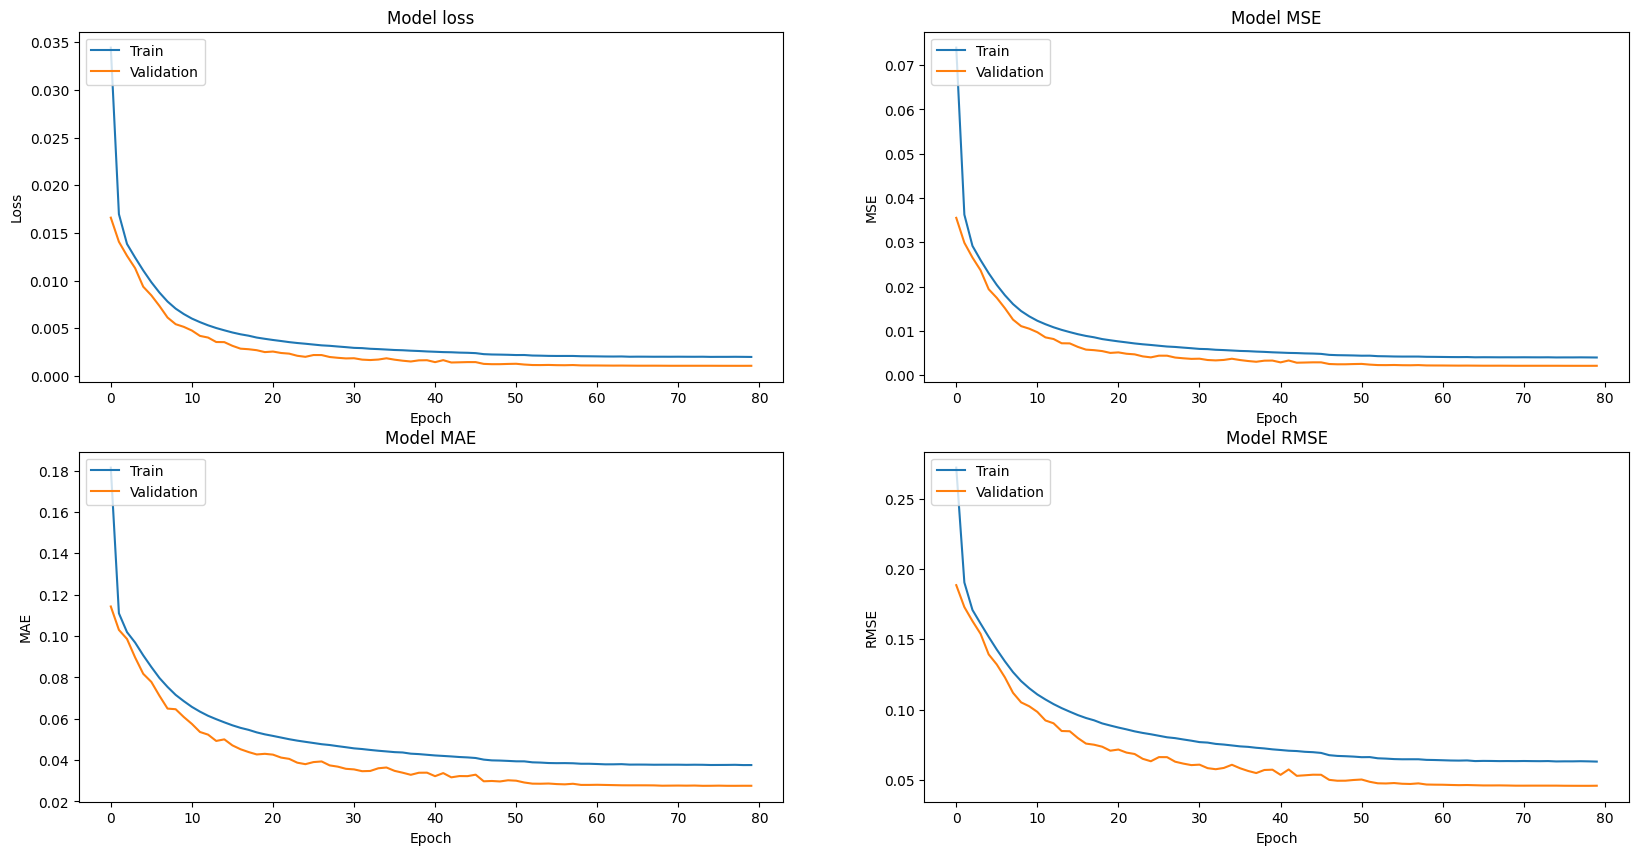

In [9]:
plt.figure(figsize=(20, 10))
# Plot the training and validation loss
plt.subplot(2, 2, 1)
plt.plot(saliency_model.history['loss'][0:])
plt.plot(saliency_model.history['val_loss'][0:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(2, 2, 2)
plt.plot(saliency_model.history['mse'][0:])
plt.plot(saliency_model.history['val_mse'][0:])
plt.title('Model MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(2, 2, 3)
plt.plot(saliency_model.history['mae'][0:])
plt.plot(saliency_model.history['val_mae'][0:])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(2, 2, 4)
plt.plot(saliency_model.history['rmse'][0:])
plt.plot(saliency_model.history['val_rmse'][0:])
plt.title('Model RMSE')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [10]:
model.save('../saved-models/new-model-64.h5')

In [11]:
import gc
del X_train 
del y_train
gc.collect()

16612

In [12]:
# evaluate model
X_test = np.concatenate([np.load(f).astype(np.uint8) for f in val_files])
y_test = np.concatenate([np.loadtxt(f"../3d-meshes/{os.path.basename(f).replace('.npy', '.txt')}").astype(np.float32) for f in val_files])
loss, mse, mae, rmse = model.evaluate(X_test, y_test, verbose=1)
print("Loss: ", loss)
print("MSE: ", mse)
print("MAE: ", mae)
print("RMSE: ", rmse)

3750/3750 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.0066 - mae: 0.0608 - mse: 0.0135 - rmse: 0.1152
Loss:  0.007526360917836428
MSE:  0.015403098426759243
MAE:  0.07049744576215744
RMSE:  0.12410835176706314
